<a href="https://colab.research.google.com/github/MarjeteV/data620/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project

Your Final project should incorporate one or both of the two main themes in this course: network analysis and text processing. If you are building a model or models, explain how you evaluate the "goodness" of the chosen model and parameters.



**Group**(The DataDriven Team): Susanna Wong, Puja Roy, Mikhail Broomes & Marjete Vucinaj

Recording: **(note to post on discusion on bright space too)**

The goal of this project is to understand the patterns and relationships within Jeopardy! questions can provide insights into the shows content evolution and difficulty distribution. This analysis will be valuable to contesters and fans interested in the structure of the quiz questions and their categorizations.

We will try to predict what category a question would be based on the body of text. We will attempt to use text processing to extract features and train initial models for predicting categories.

In [19]:
import pandas as pd
import re
import io
import networkx as nx
import numpy as np
import networkx.algorithms.bipartite as bi
import matplotlib.pyplot as plt
import nltk
from itertools import combinations
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

The dataset contains 150,000 Jeopardy! questions in CSV format, sourced from www.j-archive.com. This subset is part of a larger collection of over 216,930 questions, covering about 83% of all questions aired on the show, totaling 252,583 questions. It includes details such as question category, value (except for final rounds), question text, answer, round type, episode number, and air date.

In [20]:
df = pd.read_csv('https://raw.githubusercontent.com/MAB592/Data620/main/Assignments/Final%20Project/JEOPARDY_CSV_150000.csv')

# EDA

In [21]:
df.head()

,Unnamed: 0,Show Number,Air Date,Round,Category,Value,Question,Answer
0,0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


Count the missing values in each column

In [22]:
df.isna().sum()

Unnamed: 0        0
Show Number       0
 Air Date         0
 Round            0
 Category         0
 Value         2510
 Question         0
 Answer           2
dtype: int64

Cleaning 'Value' column: Dropping rows with missing values and remove dollar signs '$' and commas ',' from the values. Then converted datatype to floating-point numbers.


In [23]:
df = df.dropna(subset=[' Value'])

df[' Value'] = df[' Value'].replace({'\$': '', ',': ''}, regex=True).astype(float)

Cleaning 'Question' column: Some entries in this column contain html tags of images from http://www.j-archive.com/. We remove them using the code below.

In [24]:
def remove_html_tags(text):
  clean = re.compile('<.*?>')
  return re.sub(clean, '', text)

df[' Question'] = df[' Question'].apply(remove_html_tags)

In [25]:
# Will remove this code chunk after finish cleaning

df

,Unnamed: 0,Show Number,Air Date,Round,Category,Value,Question,Answer
0,0,4680,2004-12-31,Jeopardy!,HISTORY,200.0,"For the last 8 years of his life, Galileo was ...",Copernicus
1,1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200.0,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200.0,The city of Yuma in this state has a record av...,Arizona
3,3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200.0,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200.0,"Signer of the Dec. of Indep., framer of the Co...",John Adams
...,...,...,...,...,...,...,...,...
149995,149995,1525,1991-03-29,Jeopardy!,SPRECHEN SIE DEUTSCH?,100.0,"You say it to a sneezer to wish him or her ""go...",gesundheit
149996,149996,1525,1991-03-29,Jeopardy!,WORLD CITIES,200.0,Buildings in this Italian city don't stand on ...,Venice
149997,149997,1525,1991-03-29,Jeopardy!,COUNTRY MUSIC,200.0,These 2 singers were the original co-hosts of ...,Roy Clark & Buck Owens
149998,149998,1525,1991-03-29,Jeopardy!,THE NORTH POLE,200.0,It's the northernmost region of the Earth & th...,the Arctic


Identifying the unique number of elements for the following columns: Catgeory, Round and

In [26]:
len(df[' Category'].unique())

19779

In [27]:
df[' Round'].unique()

array(['Jeopardy!', 'Double Jeopardy!'], dtype=object)

In [28]:
df[' Value'].unique()

array([2.000e+02, 4.000e+02, 6.000e+02, 8.000e+02, 2.000e+03, 1.000e+03,
       1.200e+03, 1.600e+03, 3.200e+03, 5.000e+03, 1.000e+02, 3.000e+02,
       5.000e+02, 1.500e+03, 4.800e+03, 1.800e+03, 1.100e+03, 2.200e+03,
       3.400e+03, 3.000e+03, 4.000e+03, 6.800e+03, 1.900e+03, 3.100e+03,
       7.000e+02, 1.400e+03, 2.800e+03, 8.000e+03, 6.000e+03, 2.400e+03,
       1.200e+04, 3.800e+03, 2.500e+03, 6.200e+03, 1.000e+04, 7.000e+03,
       1.492e+03, 7.400e+03, 1.300e+03, 7.200e+03, 2.600e+03, 3.300e+03,
       5.400e+03, 4.500e+03, 2.100e+03, 9.000e+02, 3.600e+03, 2.127e+03,
       3.670e+02, 4.400e+03, 3.500e+03, 2.900e+03, 3.900e+03, 4.100e+03,
       4.600e+03, 1.080e+04, 2.300e+03, 5.600e+03, 1.111e+03, 8.200e+03,
       5.800e+03, 7.500e+02, 7.500e+03, 1.700e+03, 9.000e+03, 6.100e+03,
       1.020e+03, 4.700e+03, 2.021e+03, 5.200e+03, 3.389e+03, 4.200e+03,
       5.000e+00, 2.001e+03, 1.263e+03, 4.637e+03, 3.201e+03, 6.600e+03,
       3.700e+03, 2.990e+03, 5.500e+03, 1.400e+04, 

Visualizing the distribution of Rounds using bar graph. Jeopardy! and Double Jeaopardy were the highest and are majority of the rounds in the dataset.

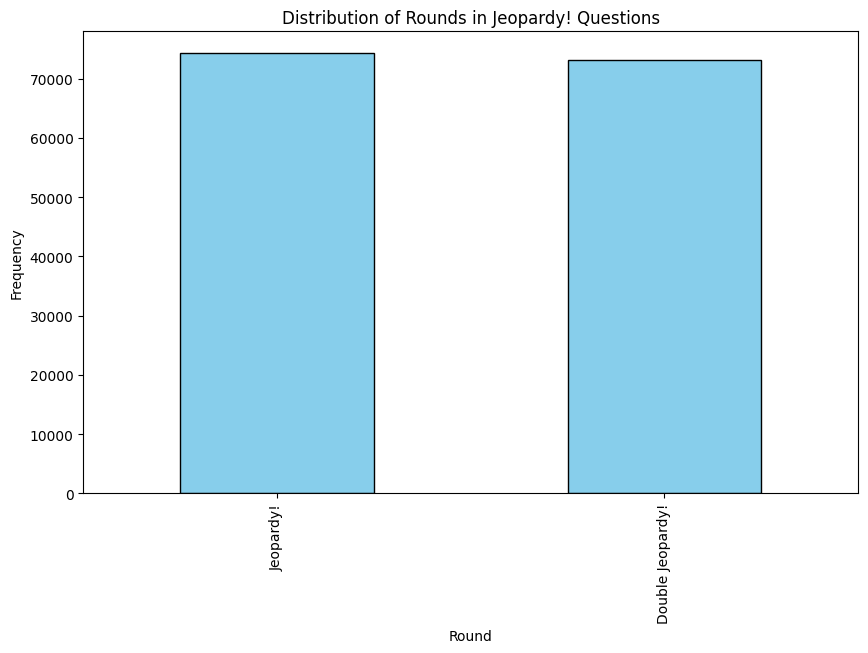

In [29]:
round_counts = df[' Round'].value_counts()
round_counts.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10, 6))

plt.xlabel('Round')
plt.ylabel('Frequency')
plt.title('Distribution of Rounds in Jeopardy! Questions')

plt.show()


Visualizing the top 10 categories in the dataset with a bar chart and inverted the y-axis to have the highest frequency at the top. Cetagories Before & After, Science and Lierature were the top 3.

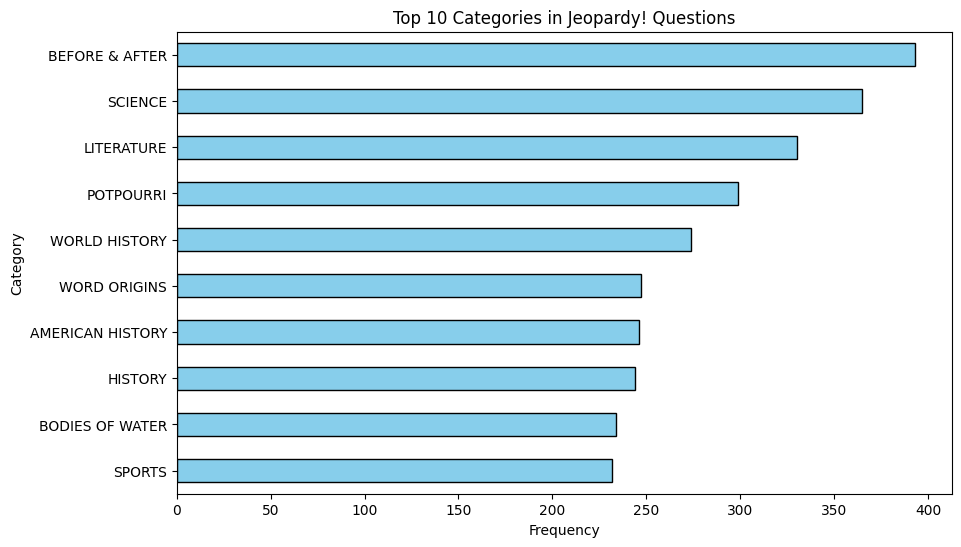

In [30]:
top_categories = df[' Category'].value_counts().head(10)
top_categories.plot(kind='barh', figsize=(10, 6), color='skyblue', edgecolor='black')
plt.xlabel('Frequency')
plt.ylabel('Category')
plt.title('Top 10 Categories in Jeopardy! Questions')
plt.gca().invert_yaxis()
plt.show()

**Do the top catergories change through out the years?**

The top categories seem to be consistent for the most part. In the past some of the categories were asked at much higher frequency, for example History was asked a 60+ times in 1997, and Before & After was asked at the highest frequency between 1997 to 2005. As we approach more recent years the categories seem to be asked in similar frequency, between 2005 and 2012 all cetagories were asked 30 times or less.

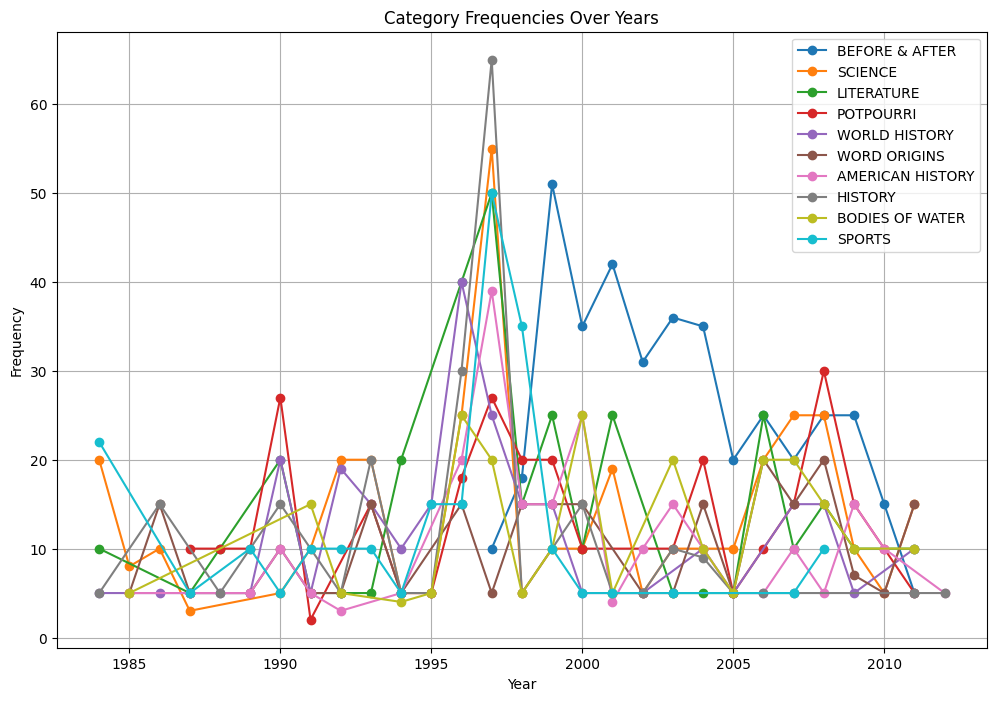

In [31]:
df[' Air Date'] = pd.to_datetime(df[' Air Date'])
df['Year'] = df[' Air Date'].dt.year

category_counts_by_year = df.groupby(['Year', ' Category']).size().reset_index(name='Count')

# Example: Plotting category frequencies over years
plt.figure(figsize=(12, 8))
for category in top_categories.index:
    data = category_counts_by_year[category_counts_by_year[' Category'] == category]
    plt.plot(data['Year'], data['Count'], marker='o', label=category)

plt.title('Category Frequencies Over Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


This graph shows the category frequencies over years for top 5 categories.


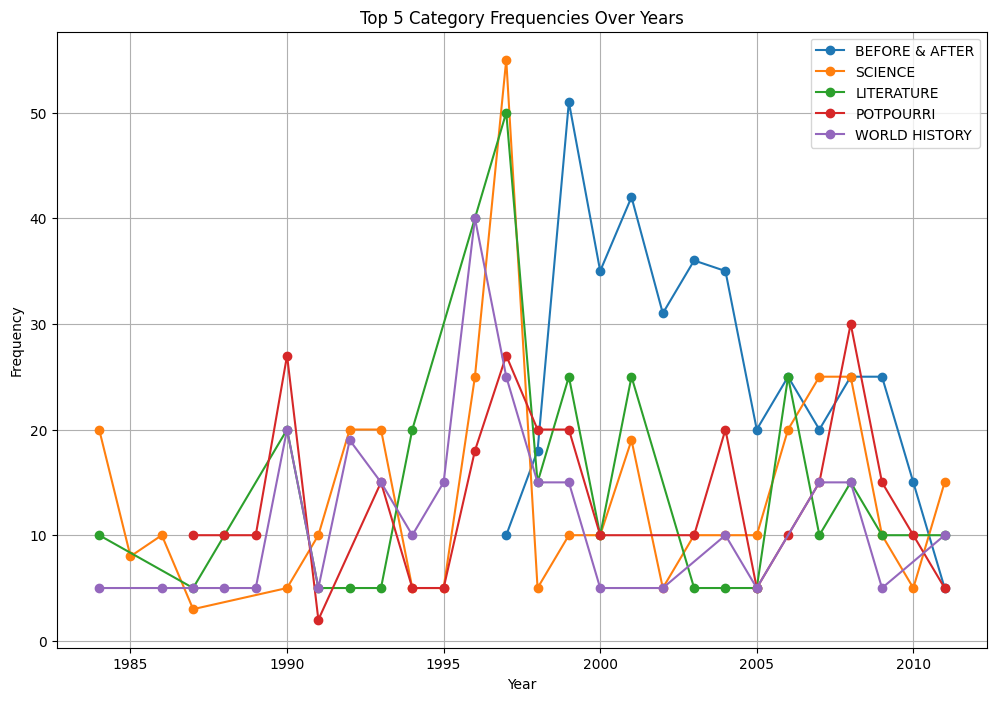

In [32]:
top_5 = category_counts_by_year.groupby(' Category')['Count'].sum().nlargest(5).index

plt.figure(figsize=(12, 8))
for category in top_5:
    data = category_counts_by_year[category_counts_by_year[' Category'] == category]
    plt.plot(data['Year'], data['Count'], marker='o', label=category)

plt.title('Top 5 Category Frequencies Over Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Text Processing

**Frequency Analysis: Identify the most common words or phrases in the questions or answers**

Text preprocessing: Define the function, convert text to lowercase, remove punctuation, parenthsis, tokenize text, and remove stop words, then apply the function to the Question column

In [33]:
def clean_text(text):
    text = re.sub(r'\([^)]*\)', '', text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\b(clue|crew)\b', '', text)
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['Cleaned_Question'] = df[' Question'].apply(clean_text)


Identify the most common words or phrases using CountVectorizer, after fitting and transforming the cleaned text, get the feature phrases, and sum the count of each. Then create a data frame and organize it by frequency and plot the common words.

In the intial code and visualization for top common words in Questions, we found that phrase asking crew members to provide clues were present in 8 out of the 20 more common words. We adjusted the code above to remove  phrases which contain parenthesis and 'crew' and 'clue'.

'New York is the top common phrase. There is a clear pattern of questions asking contestants to identify something similar ie 'also called', questions relating to names, and questions related to historical or political context.

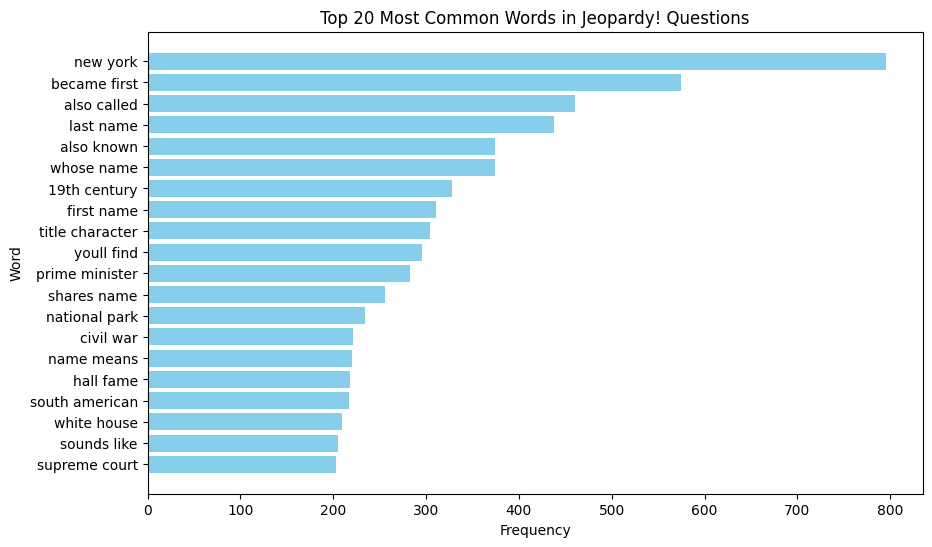

In [34]:
vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=20)

X = vectorizer.fit_transform(df['Cleaned_Question'])
words = vectorizer.get_feature_names_out()
word_counts = X.toarray().sum(axis=0)
freq_df = pd.DataFrame({'Word': words, 'Frequency': word_counts})
freq_df = freq_df.sort_values(by='Frequency', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(freq_df['Word'], freq_df['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 20 Most Common Words in Jeopardy! Questions')
plt.gca().invert_yaxis()
plt.show()

Duplicate the process for Answers column, and add function to return empty string for non-string values: NaN.

In [35]:
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation))
        words = word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
        return ' '.join(words)
    else:
        return ''

df['Cleaned_Answer'] = df[' Answer'].apply(clean_text)


The top common words in the Answers is with the highest frequency is also 'New York'; a total of 9 cities, states and countries are found in the common words of Answers. Additionally 11 of the top common words in Answers are names with historical importance.


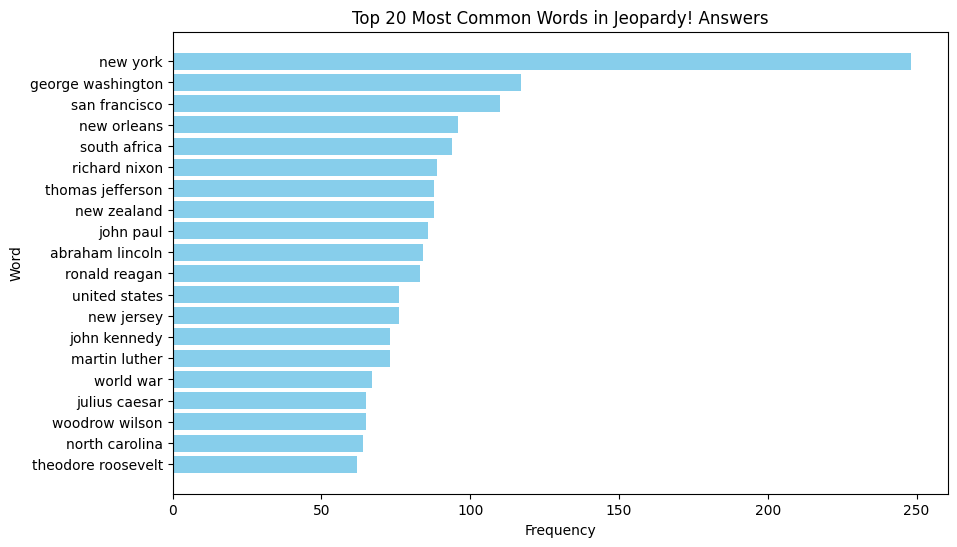

In [36]:
vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=20)
X = vectorizer.fit_transform(df['Cleaned_Answer'])
words = vectorizer.get_feature_names_out()
word_counts = X.toarray().sum(axis=0)
freq_df = pd.DataFrame({'Word': words, 'Frequency': word_counts})
freq_df = freq_df.sort_values(by='Frequency', ascending=False)

# Plot the most common words
plt.figure(figsize=(10, 6))
plt.barh(freq_df['Word'], freq_df['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 20 Most Common Words in Jeopardy! Answers')
plt.gca().invert_yaxis()
plt.show()



 **Sentiment Analysis: Determine the sentiment of questions and answers:** Both the Questions and Answers are generally around 0, which suggests the text is neutral. Almost 140,000 of answers are neutral  (0) possibly because they tend to be shorter. Around 80,000 Questions were at the sentiment score of 0, with a wider range (compared to answers) of posiitve and negative sentiment score. They might have more emotional language; examples of questions with positive and negative sentiment were printed for context.


Initialize the SentimentIntensityAnalyzer, create function that applies sentiment analysis to each question or answer text using VADER (Valence Aware Dictionary and sentiment Reasoner). Apply the function to the 'Question' and 'Answer' columns of df.




In [37]:
sid = SentimentIntensityAnalyzer()
def analyze_sentiment(text):
    if isinstance(text, str):
        sentiment_score = sid.polarity_scores(text)
        return sentiment_score['compound']
    else:
        return np.nan

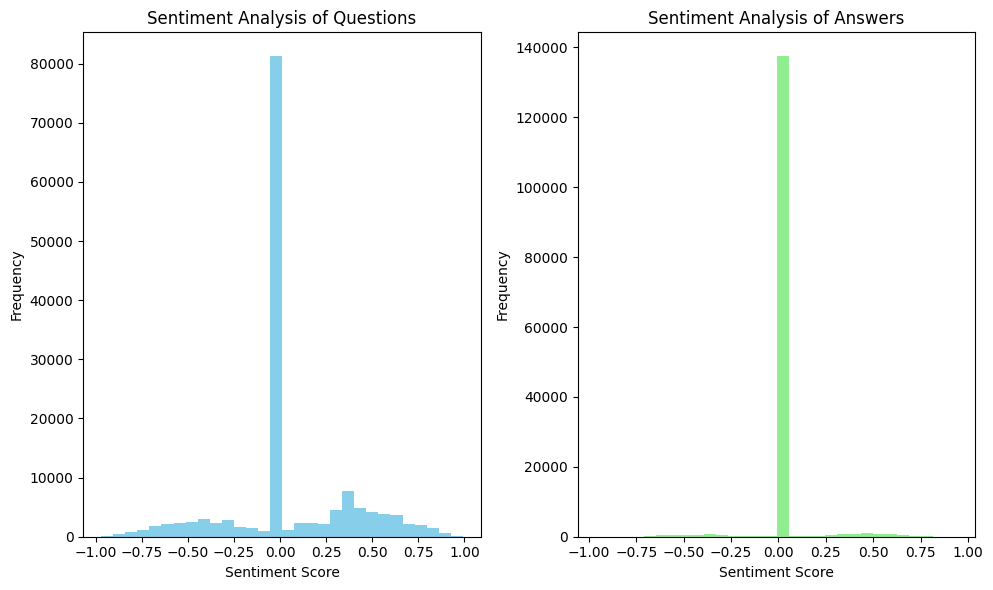

In [38]:
df['Question_Sentiment'] = df[' Question'].apply(analyze_sentiment)

df['Answer_Sentiment'] = df[' Answer'].apply(analyze_sentiment)

# Visualize sentiment scores
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.hist(df['Question_Sentiment'], bins=30, color='skyblue')
plt.title('Sentiment Analysis of Questions')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['Answer_Sentiment'], bins=30, color='lightgreen')
plt.title('Sentiment Analysis of Answers')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [39]:
positive_questions = df[df['Question_Sentiment'] > 0][' Question'].head(5)
negative_questions = df[df['Question_Sentiment'] < 0][' Question'].head(5)
print("Examples of Questions with Positive Sentiment:")
for idx, question in enumerate(positive_questions, start=1):
    print(f"{idx}. {question}")
print("\nExamples of Questions with Negative Sentiment:")
for idx, question in enumerate(negative_questions, start=1):
    print(f"{idx}. {question}")


Examples of Questions with Positive Sentiment:
1. No. 2: 1912 Olympian; football star at Carlisle Indian School; 6 MLB seasons with the Reds, Giants & Braves
2. The city of Yuma in this state has a record average of 4,055 hours of sunshine each year
3. Signer of the Dec. of Indep., framer of the Constitution of Mass., second President of the United States
4. In the title of an Aesop fable, this insect shared billing with a grasshopper
5. In the winter of 1971-72, a record 1,122 inches of snow fell at Rainier Paradise Ranger Station in this state

Examples of Questions with Negative Sentiment:
1. For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory
2. No. 8: 30 steals for the Birmingham Barons; 2,306 steals for the Bulls
3. In 1000 Rajaraja I of the Cholas battled to take this Indian Ocean island now known for its tea
4. No. 1: Lettered in hoops, football & lacrosse at Syracuse & if you think he couldn't act, ask his 11 "unclean" buddies
5. Ou

# Network Analysis


In [40]:
len(df['Show Number'].unique())


2518

In [41]:
len(df[' Category'].unique())


19779

In [42]:
G = nx.Graph()

In [43]:
categories = df[' Category'].unique()
rounds = df[' Round'].unique()
value = df[' Value'].unique()
question = df[' Question'].unique()
show_number = df['Show Number'].unique()

Creating a Co-occurence Network

In [44]:
show_categories = df.groupby('Show Number')[' Category'].apply(list)

In [45]:
co_occurrence_counts = Counter()
for categories in show_categories:
    for cat1, cat2 in combinations(sorted(categories), 2):
        co_occurrence_counts[(cat1, cat2)] += 1

In [46]:
G_cooccurrence = nx.Graph()
for (cat1, cat2), count in co_occurrence_counts.items():
    G_cooccurrence.add_edge(cat1, cat2, weight=count)

In [ ]:
pos = nx.spring_layout(G_cooccurrence)
plt.figure(figsize=(10, 8))
nx.draw(G_cooccurrence, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
edge_labels = nx.get_edge_attributes(G_cooccurrence, 'weight')
nx.draw_networkx_edge_labels(G_cooccurrence, pos, edge_labels=edge_labels)
plt.title('Co-Occurrence Network of Jeopardy! Categories')
plt.show()

In [ ]:
# Number of edges in the co-occurrence network
num_edges = len(G_cooccurrence.edges())
print(f'Number of co-occurrence connections (edges): {num_edges}')


In [ ]:
# Total number of nodes and edges
num_nodes = len(G_cooccurrence.nodes())
num_edges = len(G_cooccurrence.edges())
print(f'Number of categories (nodes): {num_nodes}')
print(f'Number of co-occurrence connections (edges): {num_edges}')

# Average degree of the nodes (average number of connections per category)
average_degree = sum(dict(G_cooccurrence.degree()).values()) / num_nodes
print(f'Average Degree: {average_degree}')

# Density of the graph (proportion of possible edges that are present)
density = nx.density(G_cooccurrence)
print(f'Density of the Network: {density}')


In [ ]:
# Get degree centrality
degree_centrality = nx.degree_centrality(G_cooccurrence)

# Sort categories by degree centrality
sorted_categories = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Display top 10 most connected categories
print('Top 10 Most Connected Categories:')
for category, centrality in sorted_categories[:10]:
    print(f'{category}: {centrality}')


In [ ]:
G.add_nodes_from(categories, bipartite=0)
G.add_nodes_from(rounds, bipartite=1)

In [ ]:
co_occurrence_counts = Counter()

# Count co-occurrences of different category pairs
for categories in show_categories:
    for cat1, cat2 in combinations(sorted(set(categories)), 2):
        co_occurrence_counts[(cat1, cat2)] += 1

# Get the most frequent co-occurrence pairs
most_common_pairs = sorted(co_occurrence_counts.items(), key=lambda x: x[1], reverse=True)

# Display top 10 most frequent co-occurrence pairs
print('Most Frequent Co-Occurrence Pairs (Top 10):')
for (cat1, cat2), count in most_common_pairs[:10]:
    print(f'{cat1} - {cat2}: {count}')

Looking at the pairs of Jeopardy categories, we can see that U.S. Geography and World History are the most common co-occurring categories. Additionally, we observe that "History" and "SPORTS" are frequently seen among other category pairs. Based on this analysis, if you are preparing for Jeopardy!, you should focus heavily on both "SPORTS" and "History."

Experimenting with filtered graph

In [ ]:
threshold = 2  # Example threshold value
filtered_edges = [(cat1, cat2, count) for (cat1, cat2), count in co_occurrence_counts.items() if count > threshold]

# Create the graph
G_cooccurrence2 = nx.Graph()
G_cooccurrence2.add_weighted_edges_from(filtered_edges)

In [ ]:
pos = nx.spring_layout(G_cooccurrence2)
plt.figure(figsize=(12, 10))
nx.draw(G_cooccurrence2, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
edge_labels = nx.get_edge_attributes(G_cooccurrence2, 'weight')
nx.draw_networkx_edge_labels(G_cooccurrence2, pos, edge_labels=edge_labels)
plt.title('Co-Occurrence Network of Jeopardy! Categories')
plt.show()

In [ ]:
pos = nx.spring_layout(G_cooccurrence2)
plt.figure(figsize=(12, 10))
nx.draw(G_cooccurrence2, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
edge_labels = nx.get_edge_attributes(G_cooccurrence2, 'weight')
nx.draw_networkx_edge_labels(G_cooccurrence2, pos, edge_labels=edge_labels)
plt.title('Co-Occurrence Network of Jeopardy! Categories')
plt.show()

In [ ]:
import plotly.graph_objects as go
pos = nx.spring_layout(G_cooccurrence)
edge_x = []
edge_y = []
for edge in G_cooccurrence.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_y.append(y0)
    edge_y.append(y1)

edge_trace = go.Scatter(x=edge_x, y=edge_y, mode='lines', line=dict(width=0.5, color='#888'))
node_x = []
node_y = []
for node in G_cooccurrence.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(x=node_x, y=node_y, mode='markers+text', text=list(G_cooccurrence.nodes()), textposition='top center')
fig = go.Figure(data=[edge_trace, node_trace])
fig.show()
